In [24]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import optuna
from matplotlib import pyplot as plt

In [25]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [26]:
hmeq = pd.read_excel('hmeq.xls')

In [27]:
hmeq.head()

,REASON,JOB,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,gDEBTINC
0,NaN,NaN,0,4400,NaN,60250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,HomeImp,Other,1,2300,37626.0,46200.0,3.0,0.0,1.0,122.266667,1.0,14.0,NaN,3
2,DebtCon,NaN,0,5400,53429.0,64505.0,5.0,NaN,0.0,69.542430,NaN,16.0,36.480236,1
3,HomeImp,Mgr,0,3600,61327.0,76484.0,9.0,NaN,2.0,202.510775,0.0,25.0,41.516390,1
4,HomeImp,Office,0,3800,51180.0,63459.0,20.0,0.0,0.0,203.751534,0.0,20.0,20.067042,1


In [28]:
hmeq.shape

(5960, 14)

In [29]:
seed = 1111
seed

1111

In [30]:
x_train, x_test, y_train, y_test = train_test_split(hmeq.drop(columns = 'BAD'), hmeq['BAD'], test_size = 1000, random_state=seed, stratify=hmeq['BAD'])

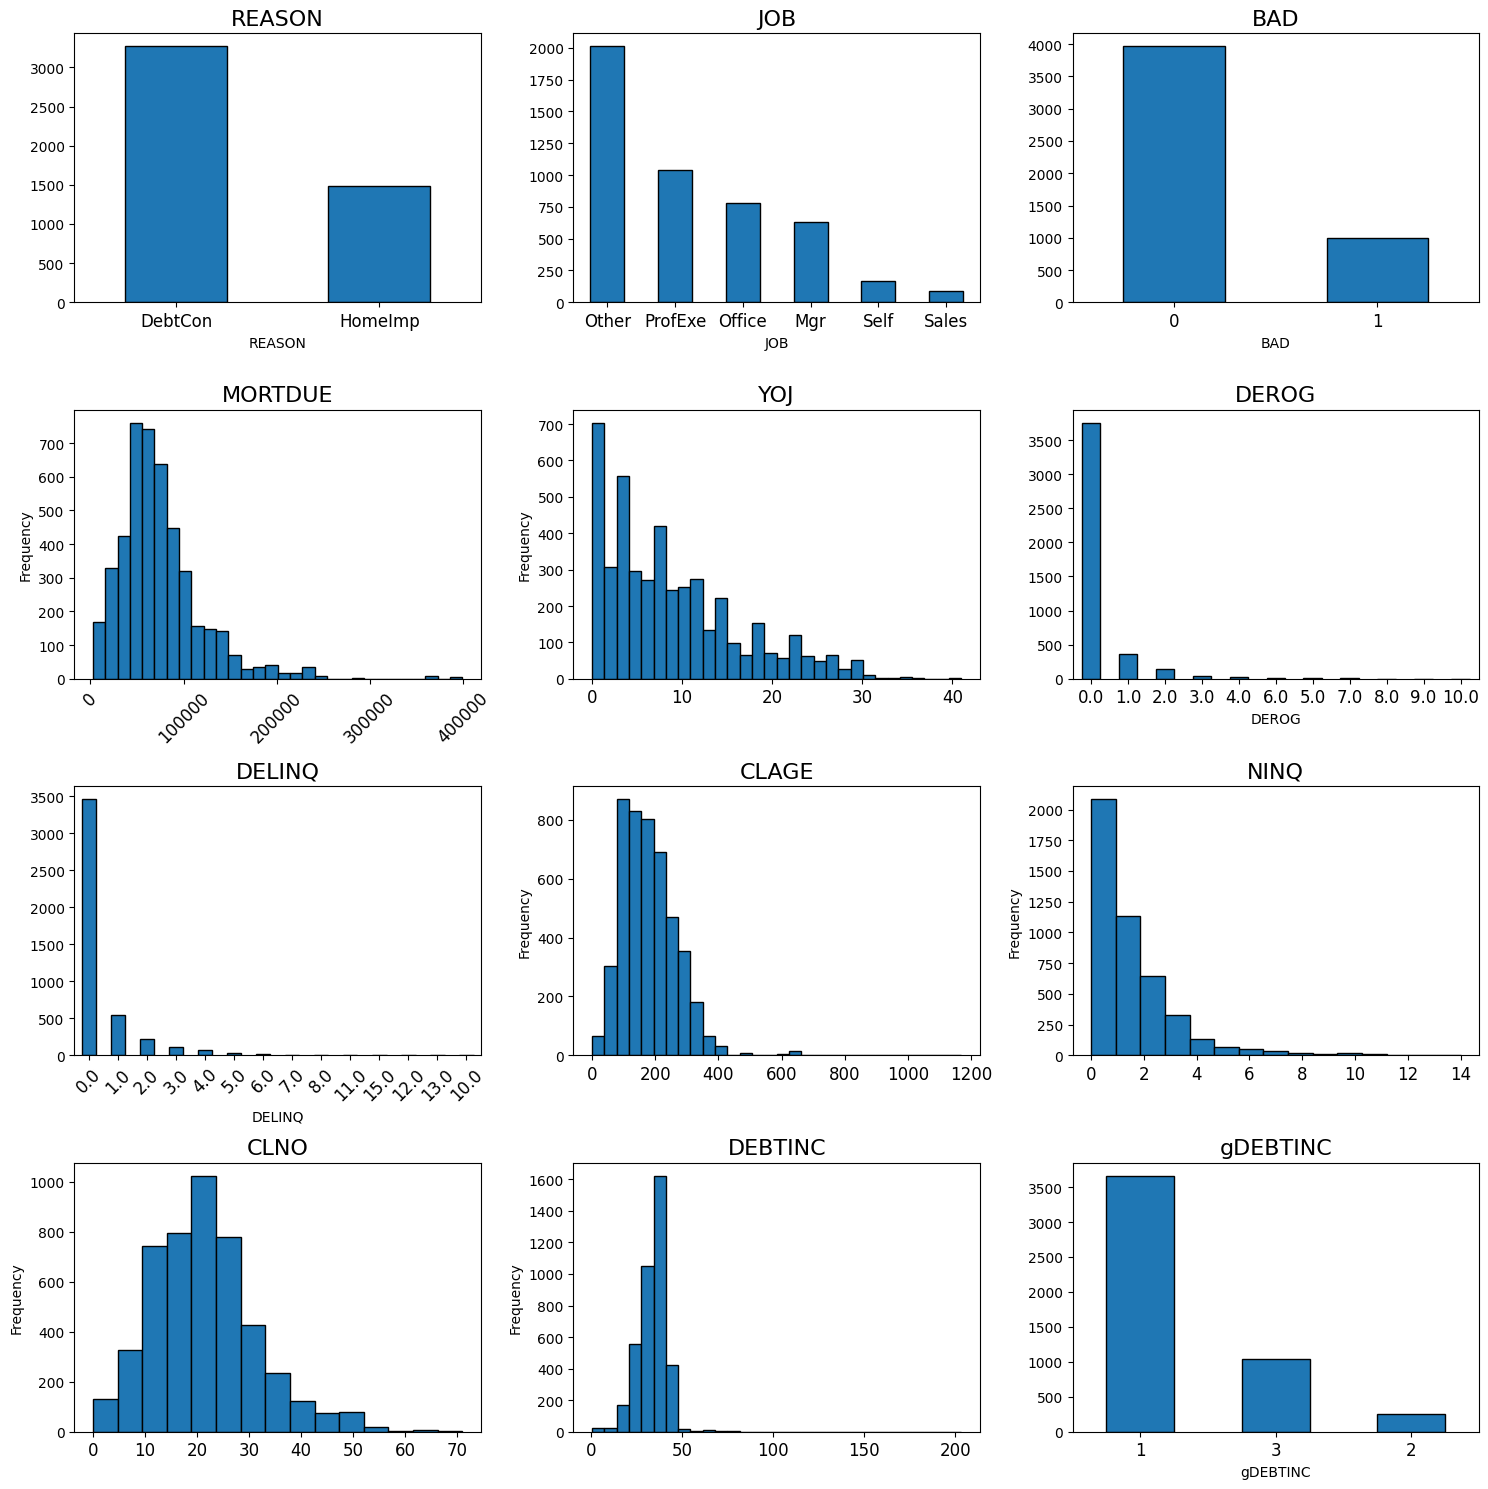

In [31]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.tight_layout(pad=4.0)

x_train['REASON'].value_counts().plot(kind='bar', ax=axs[0, 0], title="REASON", edgecolor='black')
axs[0, 0].tick_params(axis='x', rotation=0, labelsize=12)
axs[0, 0].set_title("REASON", fontsize=16)

x_train['JOB'].value_counts().plot(kind='bar', ax=axs[0, 1], title="JOB", edgecolor='black')
axs[0, 1].tick_params(axis='x', rotation=0, labelsize=12)
axs[0, 1].set_title("JOB", fontsize=16)

y_train.value_counts().plot(kind='bar', ax=axs[0, 2], title="BAD", edgecolor='black')
axs[0, 2].tick_params(axis='x', rotation=0, labelsize=12)
axs[0, 2].set_title("BAD", fontsize=16)

x_train['MORTDUE'].plot(kind='hist', bins=30, ax=axs[1, 0], title="MORTDUE", edgecolor='black')
axs[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
axs[1, 0].set_title("MORTDUE", fontsize=16)

x_train['YOJ'].plot(kind='hist', bins=30, ax=axs[1, 1], title="YOJ", edgecolor='black')
axs[1, 1].tick_params(axis='x', labelsize=12)
axs[1, 1].set_title("YOJ", fontsize=16)

x_train['DEROG'].value_counts().plot(kind='bar', ax=axs[1, 2], title="DEROG", edgecolor='black')
axs[1, 2].tick_params(axis='x', rotation=0, labelsize=12)
axs[1, 2].set_title("DEROG", fontsize=16)

x_train['DELINQ'].value_counts().plot(kind='bar', ax=axs[2, 0], title="DELINQ", edgecolor='black')
axs[2, 0].tick_params(axis='x', rotation=45, labelsize=12)
axs[2, 0].set_title("DELINQ", fontsize=16)

x_train['CLAGE'].plot(kind='hist', bins=30, ax=axs[2, 1], title="CLAGE", edgecolor='black')
axs[2, 1].tick_params(axis='x', labelsize=12)
axs[2, 1].set_title("CLAGE", fontsize=16)

x_train['NINQ'].plot(kind='hist', bins=15, ax=axs[2, 2], title="NINQ", edgecolor='black')
axs[2, 2].tick_params(axis='x', labelsize=12)
axs[2, 2].set_title("NINQ", fontsize=16)

x_train['CLNO'].plot(kind='hist', bins=15, ax=axs[3, 0], title="CLNO", edgecolor='black')
axs[3, 0].tick_params(axis='x', labelsize=12)
axs[3, 0].set_title("CLNO", fontsize=16)

x_train['DEBTINC'].plot(kind='hist', bins=30, ax=axs[3, 1], title="DEBTINC", edgecolor='black')
axs[3, 1].tick_params(axis='x', labelsize=12)
axs[3, 1].set_title("DEBTINC", fontsize=16)

x_train['gDEBTINC'].value_counts().plot(kind='bar', ax=axs[3, 2], title="gDEBTINC", edgecolor='black')
axs[3, 2].tick_params(axis='x', rotation=0, labelsize=12)
axs[3, 2].set_title("gDEBTINC", fontsize=16)

plt.tight_layout()
plt.show()


In [32]:
x_train = pd.concat([x_train.drop(columns = ['REASON', 'JOB']), pd.get_dummies(x_train.select_dtypes(include = 'object')).astype('float')], axis = 'columns')
x_test = pd.concat([x_test.drop(columns = ['REASON', 'JOB']), pd.get_dummies(x_test.select_dtypes(include = 'object')).astype('float')], axis = 'columns').reindex(columns = x_train.columns, fill_value=0)

In [33]:
x_train.isna().sum()

LOAN                 0
MORTDUE            424
VALUE               92
YOJ                437
DEROG              596
DELINQ             491
CLAGE              258
NINQ               428
CLNO               192
DEBTINC           1038
gDEBTINC             0
REASON_DebtCon       0
REASON_HomeImp       0
JOB_Mgr              0
JOB_Office           0
JOB_Other            0
JOB_ProfExe          0
JOB_Sales            0
JOB_Self             0
dtype: int64

In [34]:
names = x_train.columns 

In [35]:
imputer = KNNImputer(n_neighbors=10, weights='distance')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
x_train = pd.DataFrame(x_train, columns=names)
x_test = pd.DataFrame(x_test, columns=names)

In [36]:
y_train.value_counts()

BAD
0    3970
1     990
Name: count, dtype: int64

In [37]:
sm = SMOTE(random_state=seed, k_neighbors=10)
x_res_train, y_res_train = sm.fit_resample(x_train, y_train)

In [38]:
x_res_train.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,gDEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,21600.0,111913.975137,65935.000000,8.000000,0.000000,0.000000,111.068098,1.000000,5.0,19.429084,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16700.0,12830.000000,56465.000000,3.000000,0.000000,0.000000,301.148522,0.000000,15.0,18.251481,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,25400.0,89514.019494,45369.000000,5.793064,0.358692,2.080794,87.263847,1.147296,12.0,27.529498,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,16800.0,69284.000000,52549.524293,21.000000,0.000000,0.000000,190.693314,1.000000,20.0,35.894026,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,7800.0,44000.000000,57500.000000,11.000000,0.000000,0.000000,95.366667,0.000000,23.0,27.101556,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [39]:
y_res_train.value_counts()

BAD
0    3970
1    3970
Name: count, dtype: int64

In [40]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]  # Assuming 1 is the positive class and 0 is negative

In [41]:
scale_pos_weight

4.01010101010101

In [42]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',  # Change to 'multi:softprob' for multiclass
        'eval_metric': 'logloss',  # Use 'logloss' for binary classification
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
    }

    # Initialize XGBoost classifier
    model = xgb.XGBClassifier(**params, n_jobs = -1, random_state = seed, scale_pos_weight = scale_pos_weight)

    # Stratified Cross-validation
    skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=seed)
    
    # Optimize for accuracy
    accuracy = cross_val_score(model, x_res_train, y_res_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=-1)
    
    return accuracy.mean()

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction='maximize', sampler = sampler)  # Maximize accuracy score
study.optimize(objective, n_trials=300, n_jobs = -1)

# Best parameters
print(f"Best parameters: {study.best_params}")
print(f"Best score: {study.best_value}")


[I 2024-10-03 15:55:26,112] A new study created in memory with name: no-name-e60a81db-d644-412d-b694-32cc78e8dc81
[I 2024-10-03 15:55:34,095] Trial 1 finished with value: 0.9520119841637834 and parameters: {'lambda': 5.220181761684313e-05, 'alpha': 0.001089779417062465, 'learning_rate': 0.2142286050126801, 'n_estimators': 387, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7948369759184415, 'colsample_bytree': 0.5911076354904595, 'gamma': 0.3906155689350349}. Best is trial 1 with value: 0.9520119841637834.
[I 2024-10-03 15:55:37,450] Trial 0 finished with value: 0.9473517138067553 and parameters: {'lambda': 7.306884655263334e-06, 'alpha': 3.869405362233222e-05, 'learning_rate': 0.22727244967887994, 'n_estimators': 230, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9585646106148029, 'colsample_bytree': 0.5333622084000431, 'gamma': 0.3283592966314748}. Best is trial 1 with value: 0.9520119841637834.
[I 2024-10-03 15:55:42,001] Trial 5 finished with value: 0.94030174412383

Best parameters: {'lambda': 0.0022976108052347117, 'alpha': 0.014396154321980216, 'learning_rate': 0.062479492271966565, 'n_estimators': 370, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.5190049705875315, 'colsample_bytree': 0.7534941706554685, 'gamma': 0.046955934700650695}
Best score: 0.9593192329184055


In [43]:
best_params = study.best_params

# Train final model
final_model = xgb.XGBClassifier(**best_params, random_state = seed, n_jobs = -1, scale_pos_weight = scale_pos_weight)
final_model.fit(x_res_train, y_res_train)
y_probs = final_model.predict_proba(x_test)[:, 1]

Gini Index: 0.9390585888242711


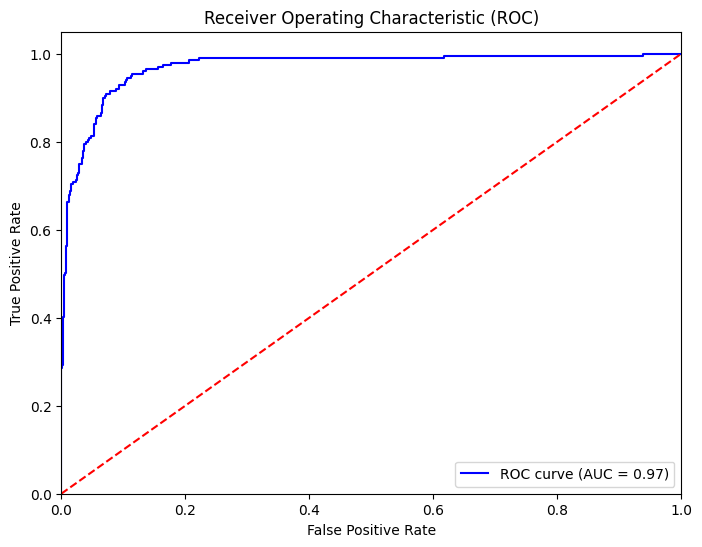

Optimal Threshold (Youden): 0.07122978568077087
Accuracy with custom threshold: 0.9
Precision with custom threshold: 0.6761565836298933
Recall with custom threshold: 0.9547738693467337

Optimal Threshold (Min Distance): 0.19009926915168762
Accuracy with custom threshold: 0.924
Precision with custom threshold: 0.7573221757322176
Recall with custom threshold: 0.9095477386934674


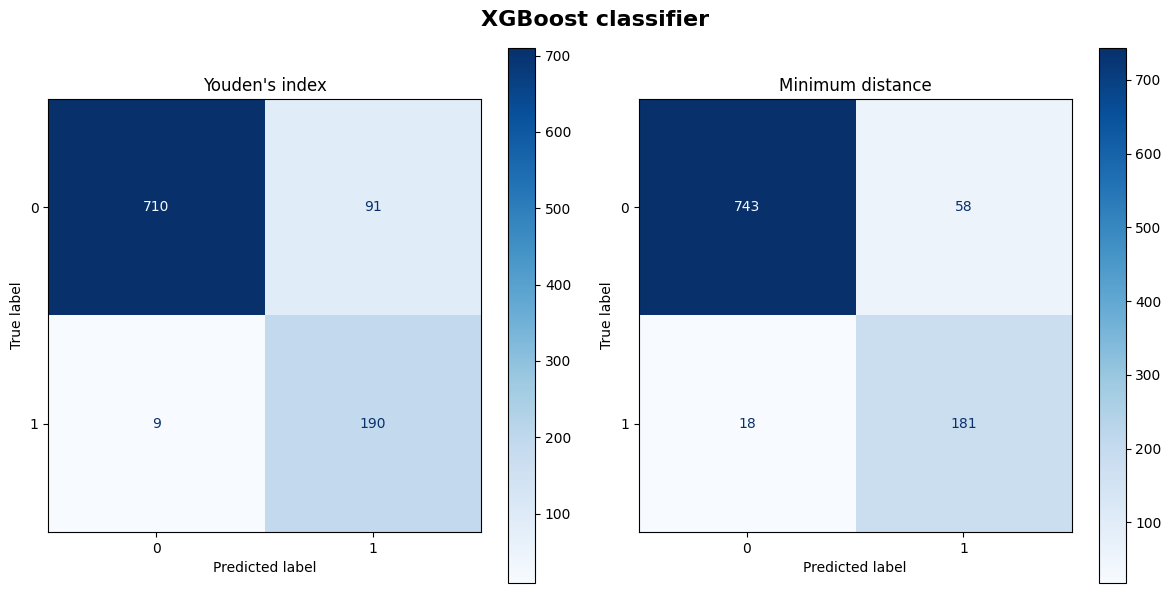

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
print(f'Gini Index: {2*roc_auc - 1}')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

#Method 1: youden_index

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold (Youden): {optimal_threshold}')

y_pred_custom_threshold1 = (y_probs >= optimal_threshold).astype(int)

accuracy1 = accuracy_score(y_test, y_pred_custom_threshold1)
precision1 = precision_score(y_test, y_pred_custom_threshold1)
recall1 = recall_score(y_test, y_pred_custom_threshold1)
print(f'Accuracy with custom threshold: {accuracy1}')
print(f'Precision with custom threshold: {precision1}')
print(f'Recall with custom threshold: {recall1}')
print()

cm1 = confusion_matrix(y_test, y_pred_custom_threshold1)

# Method 2: Minimize the distance to the point (0,1) on the ROC curve
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_idx_dist = np.argmin(distances)
optimal_threshold_dist = thresholds[optimal_idx_dist]

print(f'Optimal Threshold (Min Distance): {optimal_threshold_dist}')

# Apply the threshold to classify new data
y_pred_custom_threshold2 = (y_probs >= optimal_threshold_dist).astype(int)

# Evaluate performance with the new threshold
accuracy2 = accuracy_score(y_test, y_pred_custom_threshold2)
precision2 = precision_score(y_test, y_pred_custom_threshold2)
recall2 = recall_score(y_test, y_pred_custom_threshold2)
print(f'Accuracy with custom threshold: {accuracy2}')
print(f'Precision with custom threshold: {precision2}')
print(f'Recall with custom threshold: {recall2}')

cm2 = confusion_matrix(y_test, y_pred_custom_threshold2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(ax=axs[0], cmap='Blues', values_format='d')
axs[0].set_title("Youden's index")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title('Minimum distance')

plt.suptitle('XGBoost classifier', fontsize=16, fontweight='bold')
plt.tight_layout()


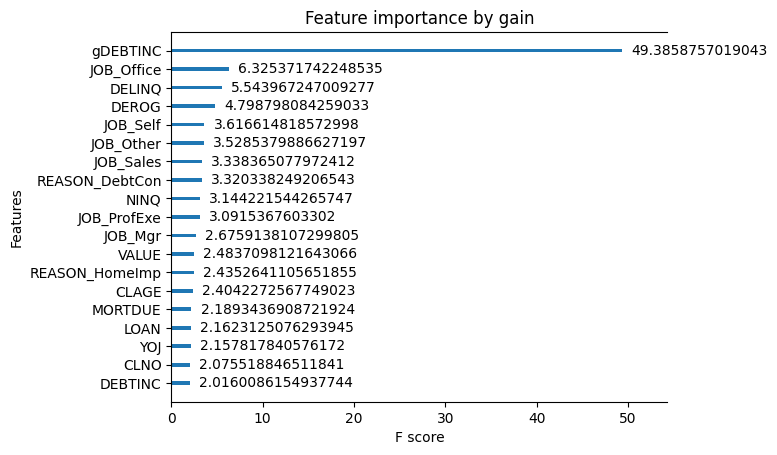

In [45]:
xgb.plot_importance(final_model, importance_type='gain')
plt.title('Feature importance by gain')
plt.grid(False)
plt.gca().spines['right'].set_visible(False)

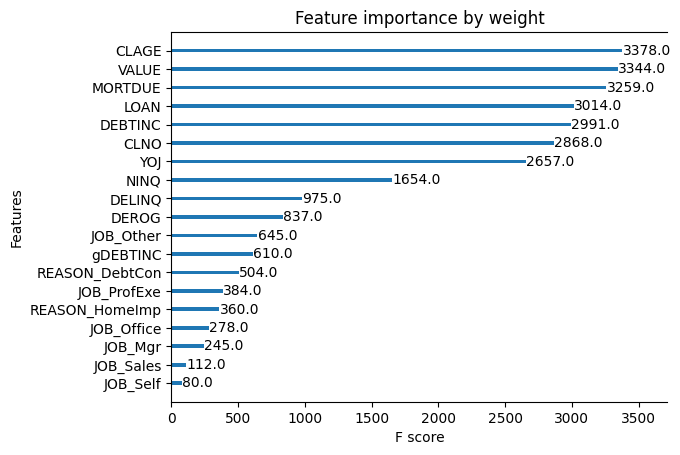

In [46]:
xgb.plot_importance(final_model, importance_type='weight')
plt.title('Feature importance by weight')
plt.grid(False)
plt.gca().spines['right'].set_visible(False)